In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: blue;
    padding: 20px;
    margin: 0;
    color: white;
    font-family: ariel;
    border-radius: 80px
}

h2,h3{
    text-align: center;
    background-color: white;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}
li
{
    font-size: 15px;
    color: charcoal;
}
</style>
""")

<h1 align = "center"> 🌈 Image Colorization with Conditional GAN 🎭 </h1>

## 🧠 Introduction

<p>Here, in this notebook, I have tried to implement the famous <b>pix2pix</b> research paper for the <b>Image colorization</b> task with <b>additional pretraining</b> to the Generator in terms of replacing it's backbone with a resnet pretrained on ImageNet followed by additional pretraining for colorization in a supervised manner using L1 loss. This pretraining has been done to deal with the fact that we will be using a much <b>smaller dataset</b> than the original paper.

pix2pix, proposed a general solution to many image-to-image tasks in deep learning which one of those was colorization. In this approach two losses are used: L1 loss, which makes it a regression task, and an adversarial (GAN) loss, which helps to solve the problem in an unsupervised manner.</p>

**Loss Function to be optimized**

$G^*=\arg \min _G \max _D \mathcal{L}_{c G A N}(G, D)+\lambda \mathcal{L}_{L 1}(G)$

**L1 loss** 

$\mathcal{L}_{L 1}(G)=\mathbb{E}_{x, y, z}\left[\|y-G(x, z)\|_1\right]$

**GAN Loss**

$\begin{aligned} \mathcal{L}_{c G A N}(G, D)=& \mathbb{E}_{x, y}[\log D(x, y)]+\\ & \mathbb{E}_{x, z}[\log (1-D(x, G(x, z))]\end{aligned}$

* x -> grayscale image (the condition introduced)
* y -> 2 channel output of generator
* z -> input noise of generator
* G -> Generator Model
* D -> Discriminator Model

---

<h1 align = "center"> 📚 Theory </h1>

## 💡 Basics of GANs

<p>2 types of models involved, <b>a generative model and a discriminative model</b></p>

* The generative model tries to find the joint probability P(X,Y) or P(X) when there are no labels where X is the set of data instances and Y is the set of labels. Then the joint probability can be used to find P(Y|X) or P(X|Y).
* The discriminative model tries to find the conditional probability P(Y|X) directly.

<p>Discriminative models try to draw boundaries in the data space, while generative models try to model how data is placed throughout the space.</p>


## 👨‍🏭 Basic Working of GANs

<p>Both the generator and the discriminator are neural networks. The generator output is connected directly to the discriminator input. Through backpropagation, the discriminator's classification provides a signal that the generator uses to update its weights.

A generative adversarial network (GAN) has two parts:</p>

* The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
* The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

## ✔ The Discriminator

<p>The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.</p> 

![](https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg)

### Training process for the Discriminator

* The Training data for the discriminator include Real data (positive examples) and Fake data (negative examples generated by the generator). 

* During discriminator training the generator does not train. Its weights remain constant while it produces examples for the discriminator to train on. The discriminator connects to two loss functions. During discriminator training, the discriminator ignores the generator loss and just uses the discriminator loss.

1. The discriminator classifies both real data and fake data from the generator.
2. The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
3. The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

## ⚗ The Generator

<p>The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.</p>

![](https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg)

The generator training includes:
* Random input noise to the generator.
* The generator network that generates the new data instances.
* The discriminator network the classifies the generator output.
* The generator loss that penalizes the generator for failing to fool the generator.


The Steps involved are:
1. Sample Random Noise 
2. Produce generaator output from the sampled random noise
3. Get the discriminator classification for the generator output
4. Calculate loss from discriminator output.
5. Backpropogate through both discriminator and generator and obtain the gradients, only updating the generator weights.

## GAN Training

<p>The GAN has to juggle the training of 2 networks and the convergence is hard to identify.

The training proceeds in the following manner:</p>
1. The discriminator trains for one or more epochs
2. The generator trains for one or more epochs
3. Repeat steps 1 and 2

## 📉 Loss Functions

<p>GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.</p>

### Minimax Loss

In the paper that introduced GANs, the generator tries to minimize the following function while the discriminator tries to maximize it:

$\begin{aligned} \mathcal{L}_{G A N}(G, D)=& \mathbb{E}_{x}[\log D(x)]+\\ & \mathbb{E}_{z}[\log (1-D(G(z))]\end{aligned}$

In this function:

* D(x) is the discriminator's estimate of the probability that real data instance x is real.
* Ex is the expected value over all real data instances.
* G(z) is the generator's output when given noise z.
* D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.
* Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).

The original GAN paper notes that the above minimax loss function can cause the GAN to get stuck in the early stages of GAN training when the discriminator's job is very easy. The paper therefore suggests modifying the generator loss so that the generator tries to maximize log D(G(z)). (**Modified Minimax Loss**)

There are other loss functions too like the **Wasserstein Loss**.

## 🥼 LAB color space

LAB is a color space just like RGB but here the 3 dimensions represent Lightness(L), Green-Redness (a) and Yellow-blueness (b) of each pixel

The main advantages of using this color space over RGB for the Image Colorization task are:
* Here, the L channel can straight away be used as the grayscale input of the image.
* The model only needs to output 2 channels.
* But if you use RGB, you have to first convert your image to grayscale, feed the grayscale image to the model and hope it will predict 3 numbers for you which is a way more difficult and unstable task due to the many more possible combinations of 3 numbers compared to two numbers.

---

# 📃 Config Class

In [ ]:
class Config:
    external_data_size = 10000
    train_size = 8000
    image_size_1 = 256
    image_size_2 = 256
    batch_size = 32
    LeakyReLU_slope = 0.2
    dropout = 0.5
    kernel_size = 4
    stride = 2
    padding = 1
    gen_lr = 2e-4
    disc_lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    lambda_l1 = 100
    gan_mode = 'vanilla'
    layers_to_cut = -2
    epochs = 20
    pretrain_lr = 1e-4

<h1>📦 Importing Packages</h1>

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
import os
from pathlib import Path
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.vgg import vgg19
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## FastAI imports + Loading in the Data

The data is a small sample of the COCO dataset for object detection and is loaded in through the external data functionality of fastai. The actual paper uses the entire ImageNet dataset while we only use 8000 training images.

In [ ]:
!pip install fastai==2.4
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.COCO_SAMPLE)
path = str(path) + "/train_sample"
paths = glob.glob(path + "/*.jpg")

In [ ]:
# Train test split
np.random.seed(42)
paths_subset = np.random.choice(paths, Config.external_data_size, replace=False) # choosing 10000 images randomly
random_idxs = np.random.permutation(Config.external_data_size) 
train_idxs = random_idxs[:Config.train_size] # choosing the first 8000 as training set
val_idxs = random_idxs[Config.train_size:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

In [ ]:
# Taking a look at the training dataset
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
class ImageDataset(Dataset):
    ''' 
    
    Class that deals with the Data Loading and preprocessing steps such as image resizing, data augmentation (horizontal flip) 
    and conversion of RGB image to LAB color space with standardization.
    
    '''
    
    def __init__(self,paths,train = True):
        if train == True:
            self.transforms = transforms.Compose([transforms.Resize((Config.image_size_1,Config.image_size_2)),
                                                 transforms.RandomHorizontalFlip()]) # Basic Data Augmentation
        elif train == False:
            self.transforms = transforms.Compose([transforms.Resize((Config.image_size_1,Config.image_size_2))])
            
        self.train = train
        self.paths = paths
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        lab = rgb2lab(img).astype("float32")
        lab = transforms.ToTensor()(lab)
        L = lab[[0],...]/50 - 1 # Standardizing L space
        ab = lab[[1,2],...]/128 # Standardizing ab space
        
        return {'L': L,
                'ab': ab}

In [ ]:
batch_size = Config.batch_size

#train dataset
train_data = ImageDataset(paths = train_paths, train=True)
# validation dataset
valid_data = ImageDataset(paths = val_paths, train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True,pin_memory = True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size,shuffle=False,pin_memory = True)

# 🧰 Utility Functions



In [ ]:
# Credits: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

class AverageMeter:
    '''
    
    Computes and stores the average and current value for the various losses involved.
    
    '''
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    disc_loss_gen = AverageMeter()
    disc_loss_real = AverageMeter()
    disc_loss = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'disc_loss_gen': disc_loss_gen,
            'disc_loss_real': disc_loss_real,
            'disc_loss': disc_loss,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        


def lab_to_rgb(L, ab):
    """
    
    Takes a batch of images and converts from LAB space to RGB
    
    """
    
    L = (L + 1.) * 50
    ab = ab * 128
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    '''
    
    Function which helps visualize and see the difference between the input image (grayscale), generated image 
    and the Real image.
    
    '''
    
    model.generator.eval()
    with torch.no_grad():
        model.prepare_input(data)
        model.forward()
#     model.generator.train()
    fake_color = model.gen_output.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        

class GANLoss(nn.Module):
    '''
    
    Class that defines the GAN loss.
    
    '''
    
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

<h1 align = 'center'> 🖼 The Generator</h1>

<p>This code implements a U-Net to be used as the generator of our GAN. The code is designed in a manner where we first build the middle part of the U-Net and then build the downsampling and upsampling modules around it. In our Final Modified implementation of this paper we use a resnet as the backbone of our generator in the downsampling module.</p>

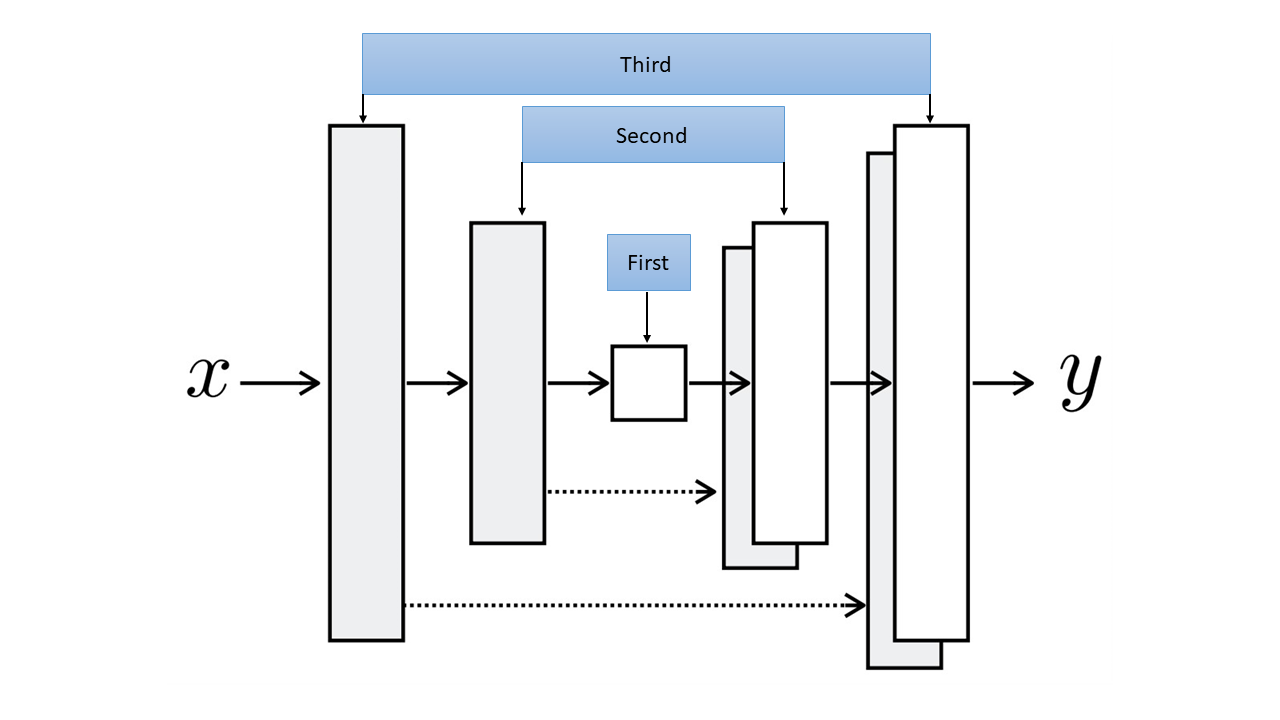

In [ ]:
# Code help for model architecture and training loop: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

class UnetBlock(nn.Module):
    '''
    
    Class that helps define the various different types of blocks used in the Generator architecture
    
    '''
    
    def __init__(self, nf, ni, submodule=None, input_channels=None, dropout=False,innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_channels is None: 
            input_channels = nf
        downconv = nn.Conv2d(input_channels, ni, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
        downrelu = nn.LeakyReLU(Config.LeakyReLU_slope, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf,kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(Config.dropout)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    '''
    
    The Generator Model Class
    
    '''
    
    def __init__(self, input_channels=1, output_channels=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_channels, out_filters, input_channels=input_channels, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

<h1 align = 'center'> 🎭 The Discriminator</h1>

<p>The discriminator being used here is working on small patches of the images instead of the image as a whole. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. </p>

In [ ]:
class Discriminator(nn.Module):
    '''
    
    The Discriminator Model Class
    
    '''
    
    def __init__(self,input_channels,num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels,num_filters,norm = False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), stride=1 if i == (n_down-1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, stride=1, norm=False, activation=False)] 
        self.model = nn.Sequential(*model)
    
    def get_layers(self, ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, norm=True, activation=True): 
        layers = [nn.Conv2d(ni, nf, kernel_size, stride, padding, bias=not norm)]          
        if norm: 
            layers += [nn.BatchNorm2d(nf)]
        if activation:
            layers += [nn.LeakyReLU(Config.LeakyReLU_slope, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# Normal Weight Initialization with mean = 0, std = 0.02

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

<h1 align = "center"> 🎨 The Main Model </h1>

<p>This is where it all comes together. First we have the functions that help us apply our modifications to this research paper. Next comes the Main Model class. First, we train the discriminator where we feed it the generated images from the generator as well as the real images and take the average of these 2 losses and apply backpropagation. Coming next to the training of the Generator model, we feed the discriminator model the fake generated images and try to fool it, and then we compute the adversarial loss. We also calculate the L1 loss which computes the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.</p>

In [ ]:
def build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1):
    '''
    
    Function that helps build the generator backbone using another pretrained model trained on imagenet for image classification
    
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=input_channels, cut=Config.layers_to_cut)
    generator = DynamicUnet(body, output_channels, (size, size)).to(device)
    return generator

def pretrain_generator(generator, train_dl, opt, criterion, epochs):
    '''
    
    Function to pretrain the generator in a supervised manner on the colorization task using L1 Loss.
    
    '''
    
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = generator(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:
class MainModel(nn.Module):
    '''
    
    The Class where it all comes together.
    
    '''
    
    def __init__(self,generator = None,gen_lr =Config.gen_lr,disc_lr = Config.disc_lr, beta1 = Config.beta1,beta2 = Config.beta2, lambda_l1 = Config.lambda_l1):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_l1 = lambda_l1
        
        if generator is None:
            self.generator = init_model(Unet(input_channels=1, output_channels=2, n_down=8, num_filters=64),self.device)
        else:
            self.generator = generator.to(self.device)
        self.discriminator = init_model(Discriminator(input_channels = 3,num_filters = 64,n_down = 3),self.device)
        self.GANloss = GANLoss(gan_mode=Config.gan_mode).to(self.device)
        self.L1loss = nn.L1Loss()
        self.gen_optim = optim.Adam(self.generator.parameters(), lr=gen_lr, betas=(beta1, beta2))
        self.disc_optim= optim.Adam(self.discriminator.parameters(), lr=disc_lr, betas=(beta1, beta2))
        
    def requires_grad(self,model,requires_grad = True):
        for p in model.parameters():
            p.requires_grad = requires_grad
            
    def prepare_input(self,data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.gen_output = self.generator(self.L)
        
    def disc_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image.detach())
        self.disc_loss_gen = self.GANloss(gen_image_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discriminator(real_image)
        self.disc_loss_real = self.GANloss(real_preds, True)
        self.disc_loss = (self.disc_loss_gen + self.disc_loss_real) * 0.5
        self.disc_loss.backward()
    
    def gen_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image)
        self.loss_G_GAN = self.GANloss(gen_image_preds, True)
        self.loss_G_L1 = self.L1loss(self.gen_output, self.ab) * self.lambda_l1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.requires_grad(self.discriminator, True)
        self.disc_optim.zero_grad()
        self.disc_backward()
        self.disc_optim.step()
        
        self.generator.train()
        self.requires_grad(self.discriminator, False) 
        self.gen_optim.zero_grad()
        self.gen_backward()
        self.gen_optim.step()

<h1> 🚂 Training Function</h1>

In [ ]:
def train_model(model, train_loader, epochs, display=100):
    data = next(iter(train_loader)) 
    for epoch in range(epochs):
        loss_meter_dict = create_loss_meters() 
        i=0
        for data in tqdm(train_loader):
            model.prepare_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) 
            i+=1
            if i % display == 0:
                print(f"\nEpoch {epoch+1}/{epochs}")
                print(f"Iteration {i}/{len(train_loader)}")
                log_results(loss_meter_dict) 
                visualize(model, data, save=False) 

# 🔥 Let's Go

In [ ]:
generator = build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1)
opt = optim.Adam(generator.parameters(), lr=Config.pretrain_lr)
loss = nn.L1Loss()        
pretrain_generator(generator, train_loader, opt, loss, Config.epochs)
torch.save(generator.state_dict(), "res18-unet.pt")
generator.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(generator=generator)
train_model(model, train_loader, Config.epochs)
torch.save(model.state_dict(), "main-model.pt")

# 🧪 Model Inference

In [ ]:
path = "Path to Image"
img = PIL.Image.open(path)
img = img.resize((256, 256))
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.generator(img.unsqueeze(0).to(device))
    gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
plt.imshow(img)
plt.imshow(gen_output)